In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_path = '../input/flickr8k/Images'

In [3]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
from tensorflow.keras.applications.densenet import preprocess_input

# This fn loads an image from disk, converts it into a normalized NumPy array, and resizes it so it can
# be fed into a CNN.
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = preprocess_input(img)
    return img

# It visualizes sample images with their captions to validate data quality before training.
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

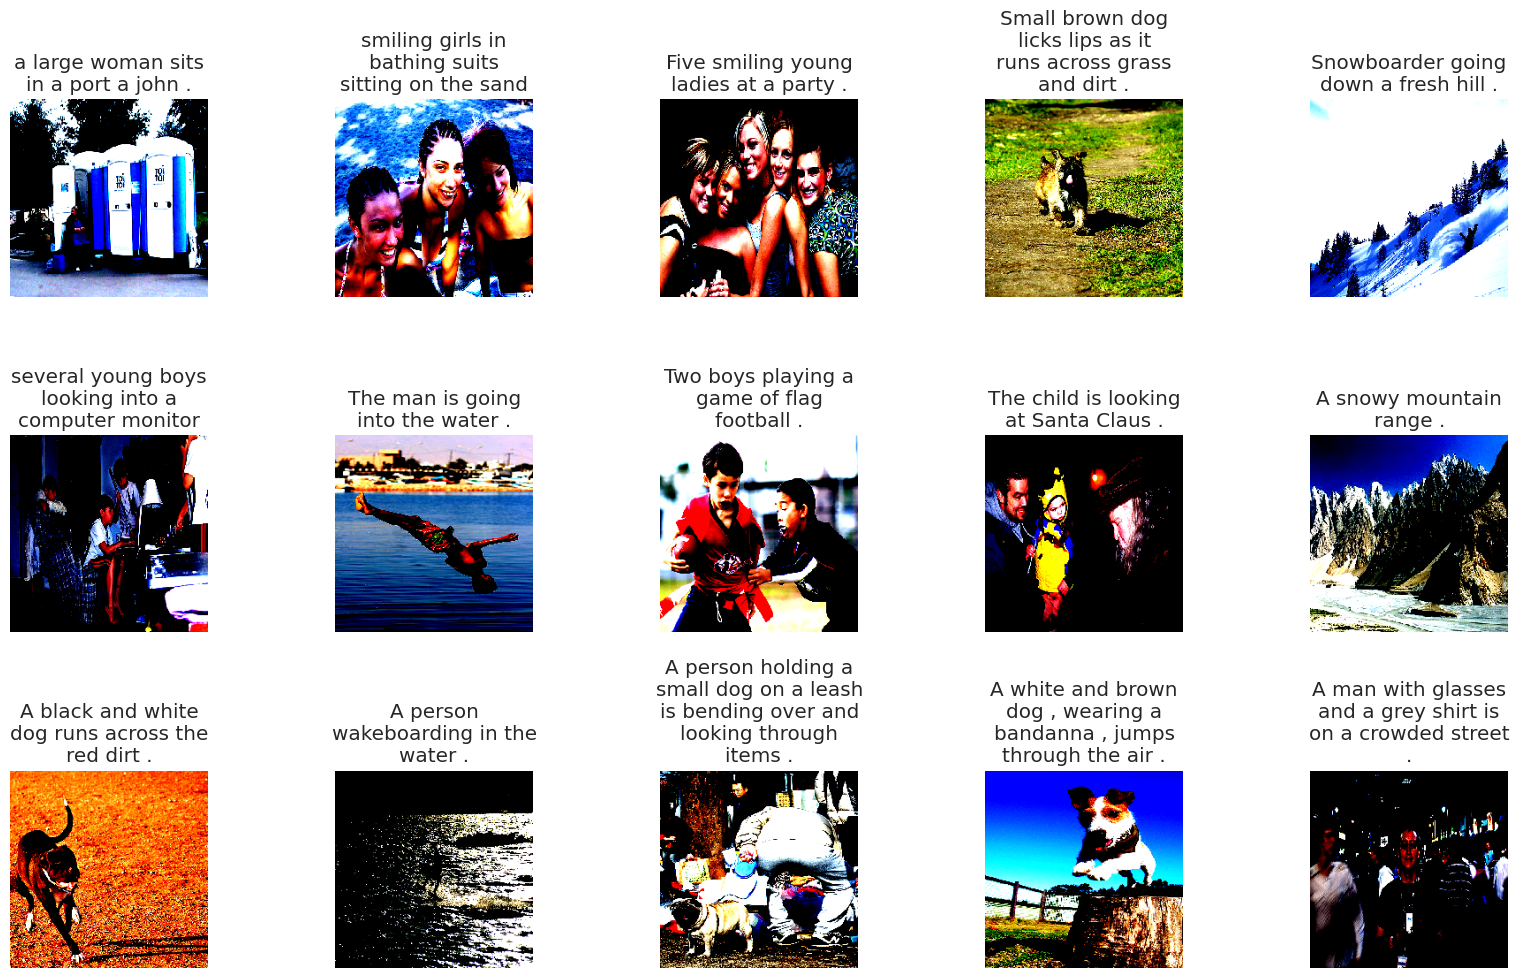

In [5]:
display_images(data.sample(15))

In [6]:
import re

def text_preprocessing(data):
    data = data.copy()
    
    data['caption'] = data['caption'].str.lower()
    
    data['caption'] = data['caption'].apply(
        lambda x: re.sub(r'[^a-zA-Z]', ' ', x)
    )
    
    data['caption'] = data['caption'].apply(
        lambda x: re.sub(r'\s+', ' ', x).strip()
    )
    
    data['caption'] = data['caption'].apply(
        lambda x: ' '.join([word for word in x.split() if len(word) > 1])
    )
    
    data['caption'] = 'startseq ' + data['caption'] + ' endseq'
    
    return data


In [7]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 313, 63, 194, 116, 2]

In [9]:
print(max_length)
print(vocab_size)

35
8427


In [10]:
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(tokenizer_json)

In [11]:
# Uses a pretrained CNN (DenseNet201) as an image encoder to extract high-level visual features, 
# which are later fed into a language model (LSTM/Transformer) to generate captions.

model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 1s 0us/step


100%|██████████| 8091/8091 [12:15<00:00, 11.00it/s]


In [12]:
class CustomDataGenerator(Sequence):
    """
    Custom data generator for training neural network models with image and text data.

    Args:
        df (pd.DataFrame): DataFrame containing image file names (`X_col`) and captions (`y_col`).
        X_col (str): Column name in the DataFrame containing image file names.
        y_col (str): Column name in the DataFrame containing captions.
        batch_size (int): Number of samples in each batch.
        directory (str): Directory where the images are located.
        tokenizer (keras.preprocessing.text.Tokenizer): Keras text tokenizer for converting captions into sequences.
        vocab_size (int): Size of the vocabulary for tokenized captions.
        max_length (int): Maximum length of a sequence (used for padding sequences).
        features (dict): A dictionary mapping image file names to their features.
        shuffle (bool): Flag indicating whether to shuffle the data during training. Default is True.
    """

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        """
        Shuffle the DataFrame at the end of each epoch if shuffle is set to True.
        """
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return self.n // self.batch_size

    def __getitem__(self, index):
        """
        Generates one batch of data.

        Args:
            index (int): Index of the batch.

        Returns:
            tuple: A tuple (X1, X2), y where X1 is the image features, X2 is the input sequence (padded),
                   and y is the output sequence (one-hot encoded).
        """
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        """
        Extracts image features, captions, and corresponding sequences from the batch.

        Args:
            batch (pd.DataFrame): Subset of the DataFrame containing the current batch of data.

        Returns:
            tuple: A tuple (X1, X2, y) where X1 is the image features, X2 is the input sequence (padded),
                   and y is the output sequence (one-hot encoded).
        """
        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [13]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [14]:
from tensorflow.keras.utils import plot_model

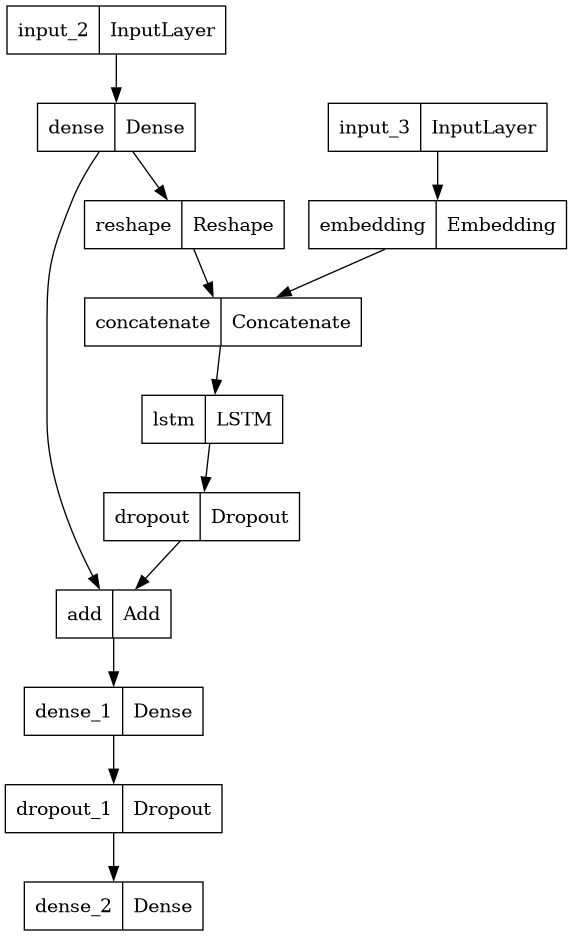

In [15]:
plot_model(caption_model)

In [16]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  491776    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 256)               0         ['dense[0][0]']               
                                                                                            

In [17]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [18]:
model_name = "model1.weights.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_weights_only=True,
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [19]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1362
Epoch 1: val_loss improved from inf to 4.24738, saving model to model1.weights.h5
537/537 [==============================] - 190s 346ms/step - loss: 5.1362 - val_loss: 4.2474 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.1880
Epoch 2: val_loss improved from 4.24738 to 3.91734, saving model to model1.weights.h5
537/537 [==============================] - 44s 81ms/step - loss: 4.1880 - val_loss: 3.9173 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.9163
Epoch 3: val_loss improved from 3.91734 to 3.76446, saving model to model1.weights.h5
537/537 [==============================] - 40s 74ms/step - loss: 3.9163 - val_loss: 3.7645 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7540
Epoch 4: val_loss improved from 3.76446 to 3.69980, saving model to model1.weights.h5
537/537 [=============================

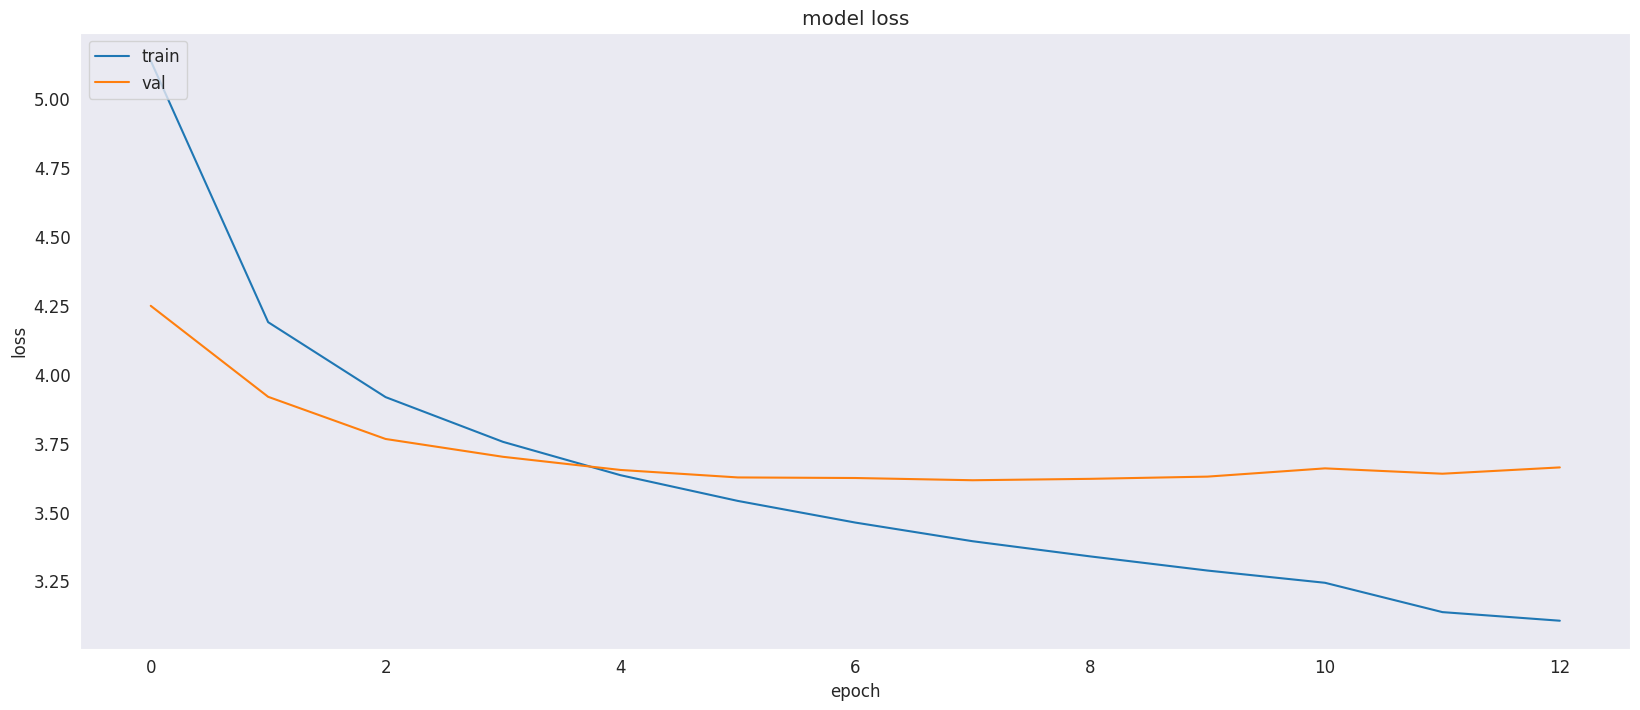

In [20]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [22]:
def predict_caption(model, image_name, tokenizer, max_length, features):
    # Get image feature and add batch dimension
    feature = features[image_name]          # shape: (1920,)
    feature = feature.reshape((1, 1920))     # shape: (1, 1920)

    in_text = "startseq"

    for _ in range(max_length):
        # Convert text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict next word
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == "endseq":
            break

    return in_text.replace("startseq", "").replace("endseq", "").strip()

## **Taking 15 Random Samples for Caption Prediction**

In [24]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [26]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = preprocess_input(img)
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

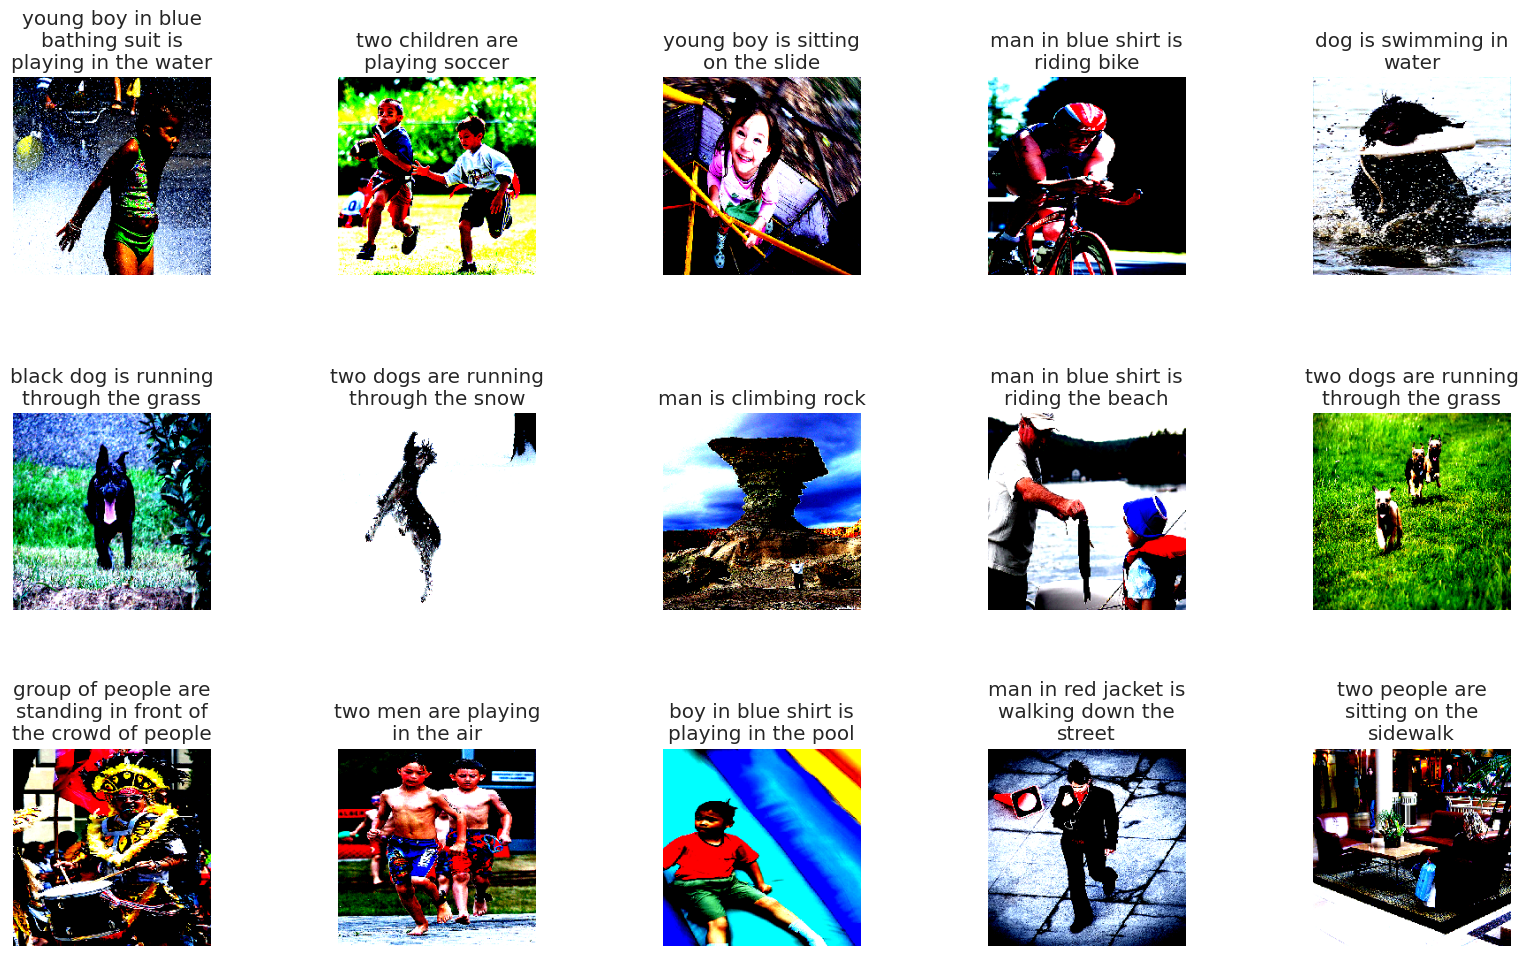

In [27]:
display_images(samples)

In [ ]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [ ]:
def evaluate_bleu(model, data, tokenizer, max_length, features):
    references = []
    candidates = []

    smooth_fn = SmoothingFunction().method4

    for image in data['image'].unique():
        # Ground truth captions
        captions = data[data['image'] == image]['caption'].tolist()
        captions = [c.replace('startseq', '').replace('endseq', '').strip() for c in captions]
        captions = [c.split() for c in captions]

        # Predicted caption
        predicted_caption = predict_caption(
            model, image, tokenizer, max_length, features
        )
        predicted_caption = predicted_caption.split()

        references.append(captions)
        candidates.append(predicted_caption)

    # BLEU scores
    bleu_1 = corpus_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
    bleu_2 = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
    bleu_3 = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
    bleu_4 = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

    print(f"BLEU-1: {bleu_1:.4f}")
    print(f"BLEU-2: {bleu_2:.4f}")
    print(f"BLEU-3: {bleu_3:.4f}")
    print(f"BLEU-4: {bleu_4:.4f}")


In [ ]:
evaluate_bleu(
    caption_model,
    test,
    tokenizer,
    max_length,
    features
)

In [ ]:
print(len(tokenizer.word_index) + 1)